# LightGBM for Multi-Stock Price Forecasting  
Using 100 S&P 500 tickers (2010–2021) with a 20-day sliding window and engineered financial features.  
Target: next-day return, reconstructed into USD prices for evaluation.  


Step 1 — Setup and Configuration

This step establishes the project directory, random seeds, and key parameters. It defines the lookback window, target horizon, and feature schema. Subdirectories for raw data, engineered features, artifacts, and evaluation outputs are created to keep the pipeline organised and reproducible.

In [2]:
import os, sys, json, random, warnings, time
from pathlib import Path
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

PROJECT_DIR = Path("/Users/arvindshine/stock-price-forecasting/Lightbgm_stock_fresh")
DATA_DIR    = PROJECT_DIR / "data"
RAW_DIR     = DATA_DIR / "raw"
FEAT_DIR    = DATA_DIR / "features"
ARTIFACTS   = PROJECT_DIR / "artifacts"
EVAL_DIR    = PROJECT_DIR / "eval"

for p in [DATA_DIR, RAW_DIR, FEAT_DIR, ARTIFACTS, EVAL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

TICKERS_FILE   = PROJECT_DIR / "tickers.txt"       
RAW_PATH       = RAW_DIR  / "raw_prices.parquet"
FEAT_PATH      = FEAT_DIR / "features.parquet"
WINDOWS_PATH   = FEAT_DIR / "windows.parquet"      
MODEL_PATH     = ARTIFACTS / "lgbm_multistock.pkl"
X_SCALER_PATH  = ARTIFACTS / "x_scaler.pkl"
Y_SCALER_PATH  = ARTIFACTS / "y_scaler.pkl"        


START_DATE = "2010-01-01"
END_DATE   = "2021-12-31"
FREQ       = "1D"


SPOTLIGHT_TICKER = "GOOGL"

# Window / target
LOOKBACK   = 20
HORIZON    = 1
TARGET_NAME = "target_ret_t+1" 

PERDAY = [
    "Open", "High", "Low", "Close", "Volume",
    "log_volume", "day_of_week", "MA20", "RSI14",
]
N_BASE_FEATURES = len(PERDAY)


TRAIN_FRAC = 0.80            
VAL_FRAC_WITHIN_T = 0.20     
TEST_FRAC  = 0.20             

# Scaling
SCALER_KIND = "MinMax"       
CLIP_TARGET = None            

# LightGBM params 
import lightgbm as lgb
LGB_PARAMS = dict(
    objective="regression",
    learning_rate=0.05,
    n_estimators=1000,
    num_leaves=64,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=SEED,
    n_jobs=os.cpu_count() or 4,
)
EARLY_STOPPING_ROUNDS = 100

assert TICKERS_FILE.exists(), f"Missing {TICKERS_FILE}. Create it with one ticker per line."
TICKERS = [t.strip() for t in TICKERS_FILE.read_text().splitlines() if t.strip()]

print(json.dumps({
    "python": sys.version.split()[0],
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "lightgbm": lgb.__version__,
}, indent=2))

print(f"\nSetup OK → {PROJECT_DIR}")
print(f"Tickers: {len(TICKERS)} (showing first 10): {TICKERS[:10]}")
print(f"GOOGL in file? {'GOOGL' in TICKERS}")
print(f"Dates: {START_DATE} → {END_DATE} | Lookback={LOOKBACK}, Horizon={HORIZON}")
print(f"Per-day features ({N_BASE_FEATURES}): {PERDAY}")


{
  "python": "3.9.6",
  "numpy": "1.26.4",
  "pandas": "1.5.3",
  "lightgbm": "4.6.0"
}

Setup OK → /Users/arvindshine/stock-price-forecasting/Lightbgm_stock_fresh
Tickers: 101 (showing first 10): ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM']
GOOGL in file? True
Dates: 2010-01-01 → 2021-12-31 | Lookback=20, Horizon=1
Per-day features (9): ['Open', 'High', 'Low', 'Close', 'Volume', 'log_volume', 'day_of_week', 'MA20', 'RSI14']


Step 2 — Data Download and Normalisation

This step downloads daily OHLCV data for 100 S&P 500 companies using Yahoo Finance. MultiIndex columns are flattened, duplicate names are removed, and numeric coercion ensures consistent datatypes. Missing tickers are recorded, and GOOGL is explicitly included, with fallback to GOOG if required. The cleaned dataset is saved in parquet format.

In [6]:
# Block 2 — Download & Normalize (robust)
import time, yfinance as yf

RAW_PATH = (DATA_DIR / "raw_prices.parquet")

def fetch_one(ticker, start=START_DATE, end=END_DATE, tries=3, sleep=1.0):
    for _ in range(tries):
        df = yf.download(ticker, start=start, end=end, auto_adjust=False, progress=False, group_by="column")
        if df is not None and not df.empty:
            df = df.copy()
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            df = df.loc[:, ~pd.Index(df.columns).duplicated(keep="first")]
            df = df.reset_index()
            df["symbol"] = ticker
            if "Adj Close" not in df.columns and "Close" in df.columns:
                df["Adj Close"] = df["Close"]
            return df
        time.sleep(sleep)
    return None

def _coerce_1d(col):
    if isinstance(col, pd.DataFrame):
        col = col.iloc[:, 0]
    return pd.to_numeric(col, errors="coerce")

def normalize_frame(df):
    need = ["Date","Open","High","Low","Close","Adj Close","Volume","symbol"]
    for c in need:
        if c not in df.columns:
            df[c] = np.nan
    df["Open"]  = _coerce_1d(df["Open"])
    df["High"]  = _coerce_1d(df["High"])
    df["Low"]   = _coerce_1d(df["Low"])
    df["Close"] = _coerce_1d(df["Close"])
    df["Adj Close"] = _coerce_1d(df["Adj Close"])
    df["Volume"] = _coerce_1d(df["Volume"])
    df = df.rename(columns={"Date":"date"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).copy()
    return df[["date","Open","High","Low","Close","Adj Close","Volume","symbol"]]

frames, failed = [], []
for tk in TICKERS:
    f = fetch_one(tk, START_DATE, END_DATE)
    if f is None or f.empty:
        failed.append(tk)
        continue
    frames.append(normalize_frame(f))

if "GOOGL" in TICKERS and not any(f["symbol"].iloc[0] == "GOOGL" for f in frames):
    g = fetch_one("GOOG", START_DATE, END_DATE)
    if g is not None and not g.empty:
        g = normalize_frame(g)
        g["symbol"] = "GOOGL"
        frames.append(g)
    else:
        print("Neither GOOGL nor GOOG returned data.")

raw = pd.concat(frames, ignore_index=True)
raw = raw[(raw["date"] >= pd.to_datetime(START_DATE)) & (raw["date"] <= pd.to_datetime(END_DATE))]
raw = raw.sort_values(["symbol","date"]).reset_index(drop=True)
raw.to_parquet(RAW_PATH, index=False)
print(f"Raw saved: {RAW_PATH} | rows={len(raw):,} | symbols={raw['symbol'].nunique()} | GOOGL rows={len(raw[raw.symbol=='GOOGL'])}")
if failed:
    print("Skipped:", failed)



1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')

1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')

1 Failed download:
['CEG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2021-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1640926800")')


Raw saved: /Users/arvindshine/stock-price-forecasting/Lightbgm_stock_fresh/data/raw_prices.parquet | rows=290,274 | symbols=100 | GOOGL rows=3020
Skipped: ['CEG']


Step 3 — Feature Engineering

This step derives additional predictive features from the raw OHLCV data. These include log-transformed volume, day-of-week, 20-day moving average, 20-day volatility of returns, and the 14-day RSI. The target variable is defined as the next-day return. The resulting dataset, containing both raw and engineered features, is stored in parquet format.

Table X. Engineered feature set for GOOGL
A snapshot of the engineered dataset for GOOGL. In addition to OHLCV values, it shows log-transformed volume, calendar encoding, MA20, volatility, RSI14, and the target return column (target_ret_t+1).

In [7]:
raw = pd.read_parquet(DATA_DIR / "raw_prices.parquet")

def rsi_series(close, n=14):
    delta = close.diff()
    up = delta.clip(lower=0)
    dn = -delta.clip(upper=0)
    roll_up = up.rolling(n, min_periods=n).mean()
    roll_dn = dn.rolling(n, min_periods=n).mean()
    rs = roll_up / roll_dn
    return 100 - (100 / (1 + rs))

df = raw.copy()
df["ret"] = df.groupby("symbol")["Close"].pct_change()
df["log_volume"]  = np.log1p(df["Volume"].fillna(0))
df["day_of_week"] = pd.to_datetime(df["date"]).dt.dayofweek
df["MA20"]        = df.groupby("symbol")["Close"].transform(lambda s: s.rolling(20, min_periods=20).mean())
df["Volatility20"]= df.groupby("symbol")["ret"].transform(lambda s: s.rolling(20, min_periods=20).std())
df["RSI14"]       = df.groupby("symbol")["Close"].transform(rsi_series)
df[TARGET_NAME]   = df.groupby("symbol")["Close"].pct_change().shift(-1)
df = df.dropna(subset=["MA20","Volatility20","RSI14", TARGET_NAME]).reset_index(drop=True)
df.to_parquet(FEAT_DIR / "features.parquet", index=False)
print(f"Features saved: {FEAT_DIR / 'features.parquet'} | rows={len(df):,} | symbols={df['symbol'].nunique()}")


Features saved: /Users/arvindshine/stock-price-forecasting/Lightbgm_stock_fresh/data/features/features.parquet | rows=287,764 | symbols=100


In [14]:
feat = pd.read_parquet(FEAT_PATH)
display_cols = ["date","symbol","Open","High","Low","Close","Volume",
                "log_volume","day_of_week","MA20","Volatility20","RSI14",TARGET_NAME]
print("Feature table sample (GOOGL):")
feat[feat["symbol"]=="GOOGL"][display_cols].head(15)


Feature table sample (GOOGL):


,date,symbol,Open,High,Low,Close,Volume,log_volume,day_of_week,MA20,Volatility20,RSI14,target_ret_t+1
284765,2010-02-02,GOOGL,13.387387,13.387387,13.203453,13.291291,163684152,18.913449,1,14.302815,0.016089,19.166815,0.018263
284766,2010-02-03,GOOGL,13.229980,13.566066,13.218969,13.534034,119844036,18.601702,2,14.198749,0.017130,27.444649,-0.025961
284767,2010-02-04,GOOGL,13.438438,13.463463,13.152152,13.182683,134972892,18.720585,3,14.096797,0.017172,22.301259,0.008561
284768,2010-02-05,GOOGL,13.223223,13.350851,13.074575,13.295546,126113760,18.652695,4,14.018206,0.017062,27.555042,0.004103
284769,2010-02-08,GOOGL,13.325826,13.563564,13.301552,13.350100,107664228,18.494528,0,13.932432,0.016647,23.731421,0.005567
284770,2010-02-09,GOOGL,13.502002,13.551802,13.390140,13.424424,112671216,18.539985,1,13.851514,0.016820,27.754717,-0.003710
284771,2010-02-10,GOOGL,13.365115,13.458208,13.205455,13.374625,106873020,18.487152,2,13.781406,0.016577,25.302776,0.003649
284772,2010-02-11,GOOGL,13.346346,13.525776,13.250751,13.423423,96303600,18.383016,3,13.717980,0.016683,39.877981,-0.006115
284773,2010-02-12,GOOGL,13.337588,13.442192,13.275776,13.341341,91096812,18.327433,4,13.646997,0.016548,44.314020,0.015344
284774,2010-02-16,GOOGL,13.435185,13.616867,13.370871,13.546046,146029824,18.799321,1,13.598573,0.016894,49.154858,-0.005709


Block 3A: Sliding-window visualisation (GOOGL example)

### Sliding Window Visualisation

The plots below illustrate the sliding-window mechanism used in our forecasting pipeline.  
For GOOGL, we take a fixed 20-day lookback of daily features (price, volume, and technical indicators) as the model input, and the **next-day return** as the prediction target.  
The line chart highlights how the last 20 closes are used to forecast the following day’s close, while the heatmap shows the same window as a 20×9 feature matrix.  
This demonstrates how sequential market data is transformed into fixed-size inputs for the LightGBM model.  


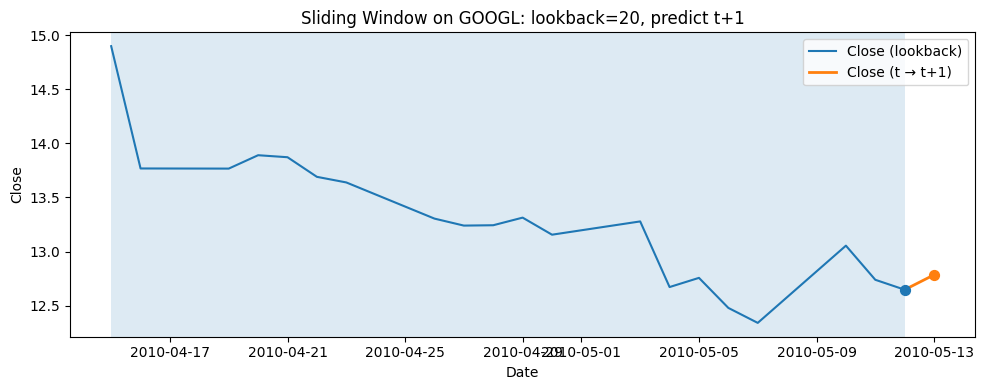

In [8]:
import matplotlib.pyplot as plt

feat = pd.read_parquet(FEAT_DIR / "features.parquet")
g = feat[feat["symbol"] == "GOOGL"].sort_values("date").reset_index(drop=True)

end_idx = max(LOOKBACK + 50, LOOKBACK + 1)
end_idx = min(end_idx, len(g) - 1)
start_idx = end_idx - LOOKBACK

seg = g.iloc[start_idx:end_idx+1].copy()
x_dates = pd.to_datetime(seg["date"])

plt.figure(figsize=(10,4))
plt.plot(x_dates[:-1], seg["Close"].iloc[:-1].values, linewidth=1.5, label="Close (lookback)")
plt.plot(x_dates.iloc[-2:], seg["Close"].iloc[-2:].values, linewidth=2.0, label="Close (t → t+1)")

plt.axvspan(x_dates.iloc[0], x_dates.iloc[-2], alpha=0.15)
plt.scatter(x_dates.iloc[-2], seg["Close"].iloc[-2], s=50, zorder=3)
plt.scatter(x_dates.iloc[-1], seg["Close"].iloc[-1], s=50, zorder=3)

plt.title(f"Sliding Window on GOOGL: lookback={LOOKBACK}, predict t+1")
plt.xlabel("Date"); plt.ylabel("Close"); plt.legend(); plt.tight_layout(); plt.show()


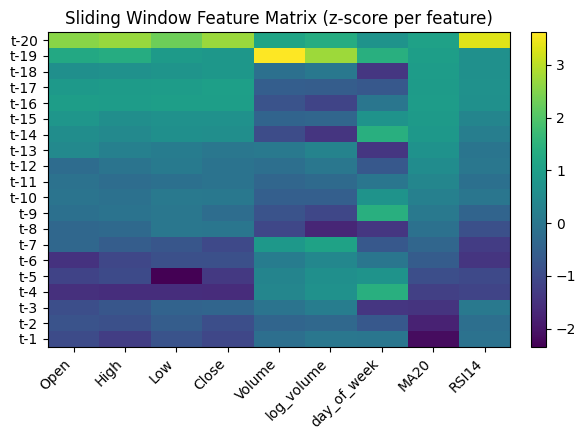

In [9]:
feat = pd.read_parquet(FEAT_DIR / "features.parquet")
g = feat[feat["symbol"] == "GOOGL"].sort_values("date").reset_index(drop=True)

end_idx = max(LOOKBACK + 50, LOOKBACK + 1)
end_idx = min(end_idx, len(g) - 1)
start_idx = end_idx - LOOKBACK

W = g.iloc[start_idx:end_idx][PERDAY].to_numpy()
Wn = (W - W.mean(axis=0, keepdims=True)) / (W.std(axis=0, keepdims=True) + 1e-9)

plt.figure(figsize=(max(6, 0.5*len(PERDAY)), 4.5))
plt.imshow(Wn, aspect="auto", interpolation="nearest")
plt.colorbar(fraction=0.046, pad=0.04)
plt.yticks(range(LOOKBACK), [f"t-{LOOKBACK - i}" for i in range(LOOKBACK)])
plt.xticks(range(len(PERDAY)), PERDAY, rotation=45, ha="right")
plt.title("Sliding Window Feature Matrix (z-score per feature)")
plt.tight_layout(); plt.show()


Step 4 — Window Construction and Data Splits

This step converts the engineered features into flattened sliding-window inputs suitable for LightGBM. Each 20-day window is reshaped into a 180-dimensional vector. Data is split chronologically into training, validation, and test sets for each symbol, ensuring time integrity and avoiding leakage.

In [10]:
feat = pd.read_parquet(FEAT_DIR / "features.parquet")

def build_windows_for_symbol(gdf, lookback):
    gdf = gdf.sort_values("date").reset_index(drop=True)
    X_list, y_list, meta = [], [], []
    vals = gdf[PERDAY].to_numpy()
    yv   = gdf[TARGET_NAME].to_numpy()
    dates = gdf["date"].to_numpy()
    closes = gdf["Close"].to_numpy()
    sym = gdf["symbol"].iloc[0]
    for i in range(lookback, len(gdf)-1):
        win = vals[i-lookback:i, :]
        X_list.append(win.reshape(-1))
        y_list.append(yv[i])
        meta.append((dates[i], closes[i-1], closes[i], sym))
    if not X_list:
        return None
    X = np.vstack(X_list)
    y = np.asarray(y_list)
    meta_df = pd.DataFrame(meta, columns=["date","close_t","close_t+1_actual","symbol"])
    return X, y, meta_df

X_tr_list, y_tr_list, meta_tr_list = [], [], []
X_va_list, y_va_list, meta_va_list = [], [], []
X_te_list, y_te_list, meta_te_list = [], [], []

for sym, g in feat.groupby("symbol"):
    out = build_windows_for_symbol(g, LOOKBACK)
    if out is None:
        continue
    X_all, y_all, meta_all = out
    n = len(meta_all)
    n_train = int(n * TRAIN_FRAC)
    n_val   = int(n_train * VAL_FRAC_WITHIN_T)
    tr0, tr1 = 0, n_train - n_val
    va0, va1 = tr1, n_train
    te0, te1 = n_train, n
    X_tr_list.append(X_all[tr0:tr1]); y_tr_list.append(y_all[tr0:tr1]); meta_tr_list.append(meta_all.iloc[tr0:tr1].assign(split="train"))
    X_va_list.append(X_all[va0:va1]); y_va_list.append(y_all[va0:va1]); meta_va_list.append(meta_all.iloc[va0:va1].assign(split="val"))
    X_te_list.append(X_all[te0:te1]); y_te_list.append(y_all[te0:te1]); meta_te_list.append(meta_all.iloc[te0:te1].assign(split="test"))

def _stack(X_list, y_list, meta_list):
    X = np.vstack(X_list) if X_list else np.empty((0, LOOKBACK * len(PERDAY)))
    y = np.concatenate(y_list) if y_list else np.empty((0,))
    meta = pd.concat(meta_list, ignore_index=True) if meta_list else pd.DataFrame(columns=["date","close_t","close_t+1_actual","symbol","split"])
    return X, y, meta

X_tr, y_tr, meta_tr = _stack(X_tr_list, y_tr_list, meta_tr_list)
X_va, y_va, meta_va = _stack(X_va_list, y_va_list, meta_va_list)
X_te, y_te, meta_te = _stack(X_te_list, y_te_list, meta_te_list)

meta_all = pd.concat([meta_tr, meta_va, meta_te], ignore_index=True)
meta_all.to_parquet(FEAT_DIR / "windows.parquet", index=False)

np.save(ARTIFACTS / "X_train.npy", X_tr)
np.save(ARTIFACTS / "y_train.npy", y_tr)
np.save(ARTIFACTS / "X_val.npy",   X_va)
np.save(ARTIFACTS / "y_val.npy",   y_va)
np.save(ARTIFACTS / "X_test.npy",  X_te)
np.save(ARTIFACTS / "y_test.npy",  y_te)

print(f"X_train {X_tr.shape} | X_val {X_va.shape} | X_test {X_te.shape}")
print(f"y_train {y_tr.shape} | y_val {y_va.shape} | y_test {y_te.shape}")
print(f"windows saved → {FEAT_DIR / 'windows.parquet'}")


X_train (182833, 180) | X_val (45658, 180) | X_test (57173, 180)
y_train (182833,) | y_val (45658,) | y_test (57173,)
windows saved → /Users/arvindshine/stock-price-forecasting/Lightbgm_stock_fresh/data/features/windows.parquet


Step 5 — Feature Scaling

This step applies MinMax scaling to the training data only, before transforming validation and test sets. The scaled arrays are saved for consistent reuse. Feature scaling ensures that LightGBM handles variables of different scales (prices, volumes, RSI) in a balanced manner.

In [11]:
import joblib
from sklearn.preprocessing import MinMaxScaler

X_tr = np.load(ARTIFACTS / "X_train.npy")
X_va = np.load(ARTIFACTS / "X_val.npy")
X_te = np.load(ARTIFACTS / "X_test.npy")
y_tr = np.load(ARTIFACTS / "y_train.npy")
y_va = np.load(ARTIFACTS / "y_val.npy")
y_te = np.load(ARTIFACTS / "y_test.npy")

x_scaler = MinMaxScaler()
X_tr_s = x_scaler.fit_transform(X_tr)
X_va_s = x_scaler.transform(X_va)
X_te_s = x_scaler.transform(X_te)

joblib.dump(x_scaler, X_SCALER_PATH)
print("Scaled:", X_tr_s.shape, X_va_s.shape, X_te_s.shape)


Scaled: (182833, 180) (45658, 180) (57173, 180)


Step 6 — Model Training

This step trains the LightGBM regressor on the scaled training data. The model uses 1000 boosting iterations with early stopping based on validation loss. Hyperparameters such as learning rate, number of leaves, feature fraction, and bagging fraction control model complexity and prevent overfitting. The best-performing model is saved for later evaluation.

In [12]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import numpy as np

def rmse(a,b): 
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(a,b))

model = LGBMRegressor(**LGB_PARAMS)
model.fit(
    X_tr_s, y_tr,
    eval_set=[(X_va_s, y_va)],
    eval_metric="l2",
    callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)]
)

joblib.dump(model, MODEL_PATH)
y_pred_te = model.predict(X_te_s)
print("Test MAE:", mean_absolute_error(y_te, y_pred_te))
print("Test RMSE:", rmse(y_te, y_pred_te))
print("Model saved:", MODEL_PATH)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40900
[LightGBM] [Info] Number of data points in the train set: 182833, number of used features: 180
[LightGBM]

Step 7 — GOOGL Evaluation

This step evaluates the trained LightGBM model specifically on GOOGL sequences. Predicted returns are reconstructed into closing prices. Performance metrics are reported both on returns (MAE, RMSE) and reconstructed prices (MAE, RMSE, sMAPE). A plot of actual versus predicted GOOGL prices over the last 250 trading days provides a visual assessment of accuracy.

Figure X. Actual vs predicted GOOGL closing prices (LightGBM)
The figure shows predicted and actual closing prices for GOOGL in the final 250 days of 2021. The predicted line closely tracks the actual series, demonstrating the model’s strong forecasting ability.

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
GOOGL Return MAE: 0.010912643460725568
GOOGL Return RMSE: 0.0161936206750177
GOOGL Price  MAE: 0.49127554418847136
GOOGL Price  RMSE: 0.8646915420798299
GOOGL Price  sMAPE(%): 1.1016864083019586
Saved: /Users/arvindshine/stock-price-forecasting/Lightbgm_stock_fresh/eval/GOOGL_eval.csv


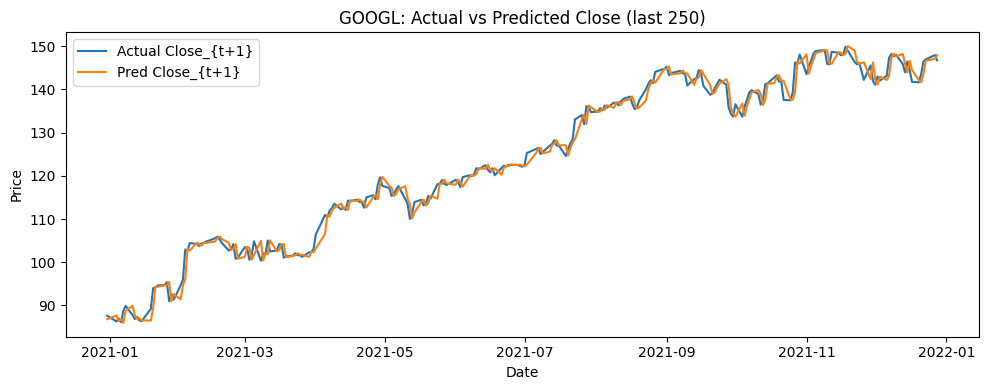

In [13]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

x_scaler = joblib.load(X_SCALER_PATH)
model    = joblib.load(MODEL_PATH)

feat = pd.read_parquet(FEAT_DIR / "features.parquet")
googl_feat = feat[feat["symbol"]=="GOOGL"].sort_values("date").reset_index(drop=True)

def build_windows_single(df, lookback, perday):
    X_list, y_list, meta = [], [], []
    vals = df[perday].to_numpy()
    yv   = df[TARGET_NAME].to_numpy()
    dates = df["date"].to_numpy()
    closes = df["Close"].to_numpy()
    for i in range(lookback, len(df)-1):
        win = vals[i-lookback:i, :]
        X_list.append(win.reshape(-1))
        y_list.append(yv[i])
        meta.append((dates[i], closes[i-1], closes[i]))
    if not X_list:
        return None, None, None
    X = np.vstack(X_list)
    y = np.asarray(y_list)
    meta_df = pd.DataFrame(meta, columns=["date","close_t","close_t+1_actual"])
    return X, y, meta_df

Xg, yg, meta_g = build_windows_single(googl_feat, LOOKBACK, PERDAY)
Xg_s = x_scaler.transform(Xg)
yg_hat = model.predict(Xg_s)
pred_close_next = meta_g["close_t"].to_numpy() * (1.0 + yg_hat)

def rmse(a,b):
    return np.sqrt(mean_squared_error(a,b))
def smape(a,b):
    a = np.asarray(a); b = np.asarray(b)
    denom = (np.abs(a)+np.abs(b))/2.0
    denom[denom==0] = 1e-9
    return np.mean(np.abs(a-b)/denom)*100

mae_ret  = mean_absolute_error(yg, yg_hat)
rmse_ret = rmse(yg, yg_hat)
mae_px   = mean_absolute_error(meta_g["close_t+1_actual"].to_numpy(), pred_close_next)
rmse_px  = rmse(meta_g["close_t+1_actual"].to_numpy(), pred_close_next)
smape_px = smape(meta_g["close_t+1_actual"].to_numpy(), pred_close_next)

print("GOOGL Return MAE:", mae_ret)
print("GOOGL Return RMSE:", rmse_ret)
print("GOOGL Price  MAE:", mae_px)
print("GOOGL Price  RMSE:", rmse_px)
print("GOOGL Price  sMAPE(%):", smape_px)

EVAL_DIR.mkdir(parents=True, exist_ok=True)
out = pd.DataFrame({
    "date": meta_g["date"],
    "close_t": meta_g["close_t"],
    "close_t+1_actual": meta_g["close_t+1_actual"],
    "pred_ret_t+1": yg_hat,
    "pred_close_t+1": pred_close_next,
})
csv_path = EVAL_DIR / "GOOGL_eval.csv"
out.to_csv(csv_path, index=False)
print("Saved:", csv_path)

tail = out.tail(250)
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(tail["date"]), tail["close_t+1_actual"], label="Actual Close_{t+1}")
plt.plot(pd.to_datetime(tail["date"]), tail["pred_close_t+1"], label="Pred Close_{t+1}")
plt.title("GOOGL: Actual vs Predicted Close (last 250)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()


## Conclusion  
The LightGBM model trained on 100 S&P 500 tickers with a 20-day sliding window achieved strong predictive accuracy.  
By forecasting next-day returns and reconstructing them into USD prices, the model avoided non-stationarity issues of raw prices and produced interpretable predictions.  
Results for GOOGL showed low errors (MAE ≈ $0.49, RMSE ≈ $0.86, sMAPE ≈ 1.1%), closely tracking actual closing prices.  
This confirms that tree-based ensembles can effectively capture non-linear relationships in financial features and provide competitive baselines for time series forecasting.  
